Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

# Defining the path for train and test images
## Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Test')

In [2]:
data_dir_train = pathlib.Path("CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train")
data_dir_test = pathlib.Path('CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Test')

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [5]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,labels="inferred",label_mode="categorical",batch_size=batch_size,image_size=(img_height,img_width),seed = 123,validation_split=0.2,subset="training")

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [6]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,labels="inferred",label_mode="categorical",batch_size=batch_size,image_size=(img_height,img_width),seed = 123,validation_split=0.2,subset="validation")

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [8]:
len(class_names)

9

### Visualize the data
#### create a code to visualize one instance of all the nine classes present in the dataset

class name: dermatofibroma


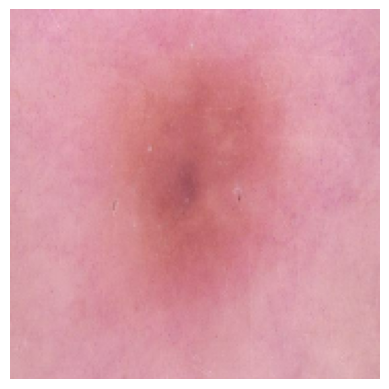

class name: vascular lesion


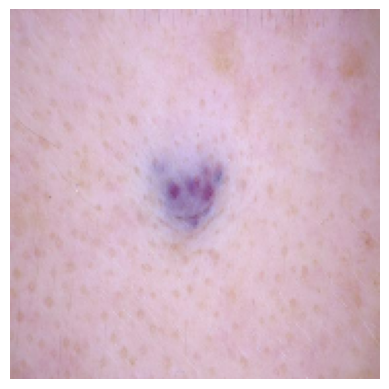

class name: melanoma


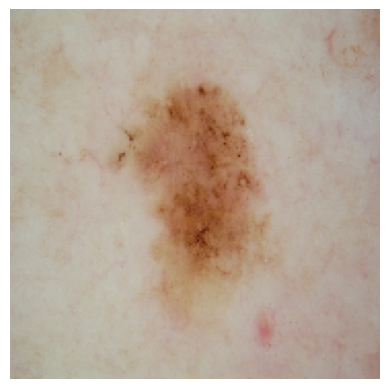

class name: pigmented benign keratosis


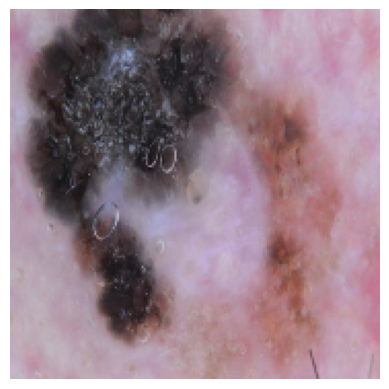

class name: nevus


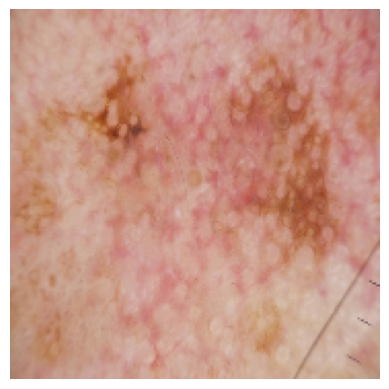

class name: basal cell carcinoma


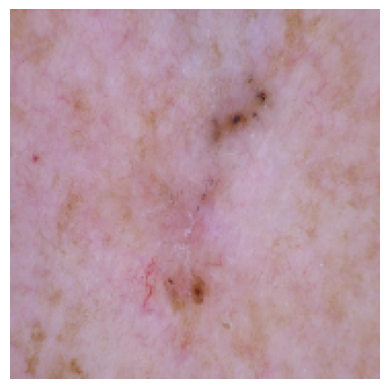

class name: seborrheic keratosis


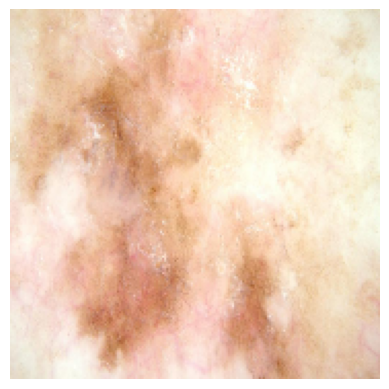

class name: squamous cell carcinoma


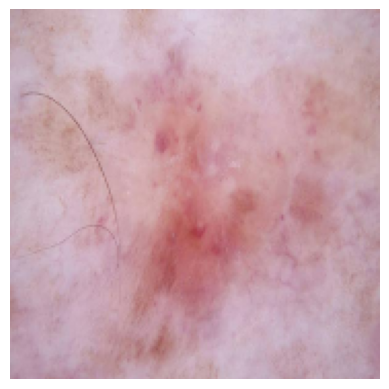

class name: actinic keratosis


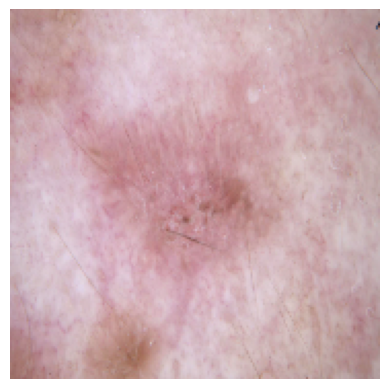

In [9]:
### your code goes here, you can use training or validation data to visualize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

class_check = {class_name:False for class_name in class_names}

for images, labels in train_ds:
  for image,label in zip(images,labels):
    class_index = tf.argmax(label)
    class_name = class_names[class_index]
    if not class_check[class_name]:
      print(f"class name: {class_name}")
      # normalizing the image
      plt.imshow(image/255.0)
      plt.axis('off')
      plt.show();
      class_check[class_name]= True

  if all(class_check.values()):
    break



In [10]:
for images,labels in train_ds:
  print(f'image_batch: {images.shape}')
  print(f'label_batch: {labels.shape}')
  break

image_batch: (32, 180, 180, 3)
label_batch: (32, 9)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
from keras.layers import MaxPool2D
from tensorflow.python.ops.gen_nn_ops import MaxPool
### Your code goes here
model = Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180, 180, 3)),
  tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
  tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
  tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dense(units=9, activation='softmax')
]

)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 32)        18464     
                                                                 
 conv2d_3 (Conv2D)           (None, 84, 84, 32)        9248      
                                                        

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 407s 2s/step - loss: 2.1354 - accuracy: 0.1843 - val_loss: 1.9174 - val_accuracy: 0.2569
Epoch 2/20
169/169 [==============================] - 384s 2s/step - loss: 1.7042 - accuracy: 0.3503 - val_loss: 1.5458 - val_accuracy: 0.4402
Epoch 3/20
169/169 [==============================] - 403s 2s/step - loss: 1.4505 - accuracy: 0.4540 - val_loss: 1.3606 - val_accuracy: 0.4692
Epoch 4/20
169/169 [==============================] - 328s 2s/step - loss: 1.2713 - accuracy: 0.5313 - val_loss: 1.2054 - val_accuracy: 0.5561
Epoch 5/20
169/169 [==============================] - 314s 2s/step - loss: 1.1015 - accuracy: 0.5898 - val_loss: 1.1889 - val_accuracy: 0.5857
Epoch 6/20
169/169 [==============================] - 322s 2s/step - loss: 0.9294 - accuracy: 0.6671 - val_loss: 1.0356 - val_accuracy: 0.6125
Epoch 7/20
169/169 [==============================] - 322s 2s/step - loss: 0.7228 - accuracy: 0.7504 - val_loss: 0.9189 - val_accuracy: 0.6882

### Visualizing training results

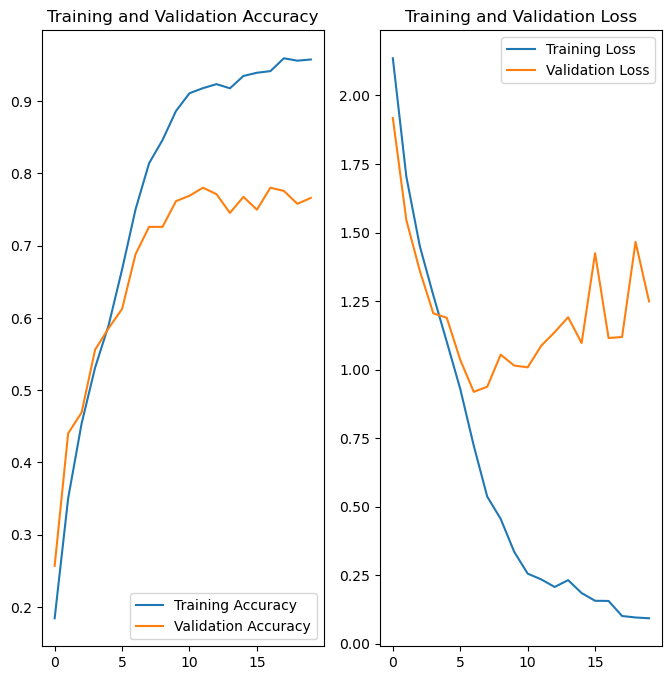

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

In [17]:
# As the number of Epoch(interations) increases, the model become overfit.
# As we are limited with the data, lets do data augmentation to produce different variants of existing data.


### Write your findings here

In [ ]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

# Given that skin cancer can have different shapes and colors depending on the cancer type, 
# I would do data augmentation with rotation(to capture different angles),
# brightness(differnt shades), and also include flit



In [19]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    brightness_range=[0.5, 1.5],
    width_shift_range=0.2, 
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',validation_split=0.2)

(180, 180, 3)
1


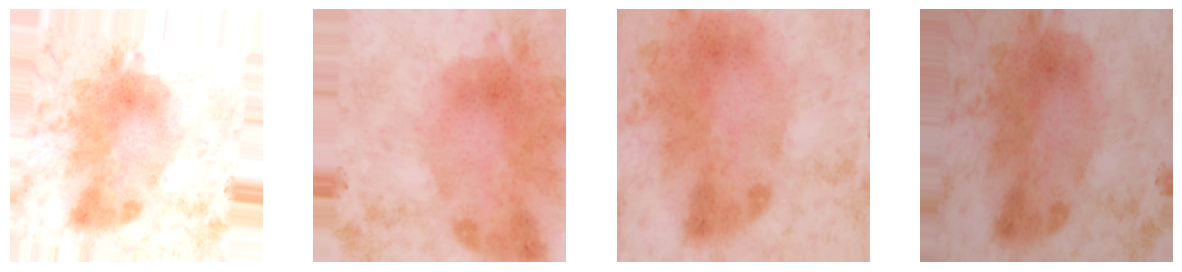

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
for image,label in train_ds.take(1):
    original_image = image[0].numpy()
    print(original_image.shape)
    original_image = original_image.reshape((1,)+original_image.shape)
    data_itr = datagen.flow(original_image,batch_size=1)
    print(data_itr.batch_size)
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
    for i in range(4):
        image_gen = next(data_itr)[0].astype('uint8')
        ax[i].imshow(image_gen)
        ax[i].axis('off')

### Todo:
### Create the model, compile and train the model


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model_with_augm_dropout = Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180, 180, 3)),
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=9, activation='softmax')
])


### Compiling the model

In [22]:
## Your code goes here
model_with_augm_dropout.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

### Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs
train_generator = datagen.flow_from_directory(data_dir_train,
                                              class_mode="categorical",
                                              batch_size=batch_size,
                                              target_size=(img_height,img_width),
                                              seed = 123,
                                              subset="training")


history = model_with_augm_dropout.fit_generator(train_generator,validation_data=val_ds,epochs=epochs)


Found 5395 images belonging to 9 classes.
Epoch 1/20
169/169 [==============================] - 315s 2s/step - loss: 1.9399 - accuracy: 0.2475 - val_loss: 1.9339 - val_accuracy: 0.2383
Epoch 2/20
169/169 [==============================] - 316s 2s/step - loss: 1.8661 - accuracy: 0.2652 - val_loss: 1.8510 - val_accuracy: 0.2895
Epoch 3/20
169/169 [==============================] - 319s 2s/step - loss: 1.8176 - accuracy: 0.2817 - val_loss: 1.6946 - val_accuracy: 0.3200
Epoch 4/20
169/169 [==============================] - 335s 2s/step - loss: 1.8051 - accuracy: 0.2914 - val_loss: 1.7076 - val_accuracy: 0.3408
Epoch 5/20
169/169 [==============================] - 336s 2s/step - loss: 1.7928 - accuracy: 0.3066 - val_loss: 1.6534 - val_accuracy: 0.3608
Epoch 6/20
169/169 [==============================] - 358s 2s/step - loss: 1.7830 - accuracy: 0.3066 - val_loss: 1.7324 - val_accuracy: 0.3326
Epoch 7/20
169/169 [==============================] - 403s 2s/step - loss: 1.7604 - accuracy: 0.3171

### Visualizing the results

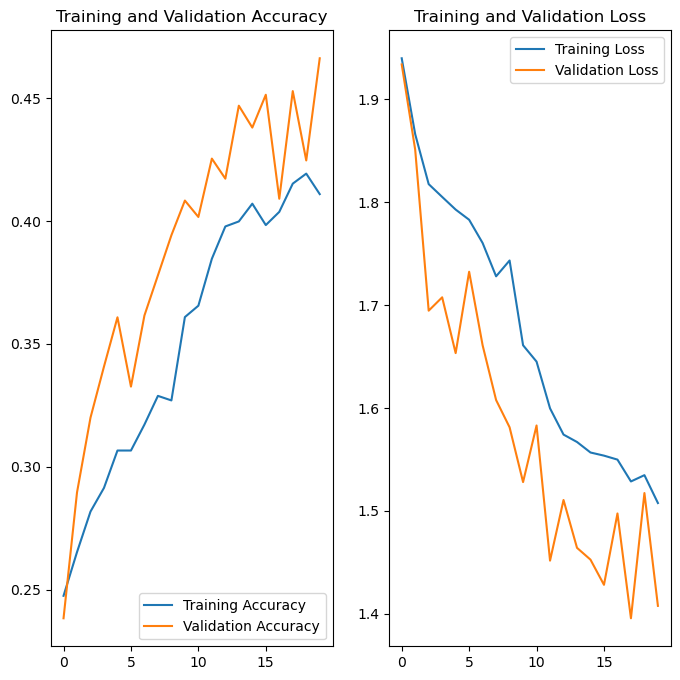

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### Summary
Model gets underfit but the loss of both training and validation gets reduced

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
## Your code goes here.
class_distribution = {class_name: 0 for class_name in class_names}
for images, labels in train_ds:
    for image,label in zip(images,labels):
        label_ind = np.argmax(label)
        class_name = class_names[label_ind]
        class_distribution[class_name] =  class_distribution[class_name] + 1

for class_name,count in class_distribution.items():
    print(f"Class '{class_name}': {count} samples")

Class 'actinic keratosis': 493 samples
Class 'basal cell carcinoma': 721 samples
Class 'dermatofibroma': 455 samples
Class 'melanoma': 755 samples
Class 'nevus': 677 samples
Class 'pigmented benign keratosis': 773 samples
Class 'seborrheic keratosis': 456 samples
Class 'squamous cell carcinoma': 569 samples
Class 'vascular lesion': 493 samples


In [27]:
index = class_distribution.keys()
count = class_distribution.values()
dist = pd.DataFrame({'index': index, 'count': count})
dist

,index,count
0,actinic keratosis,493
1,basal cell carcinoma,721
2,dermatofibroma,455
3,melanoma,755
4,nevus,677
5,pigmented benign keratosis,773
6,seborrheic keratosis,456
7,squamous cell carcinoma,569
8,vascular lesion,493


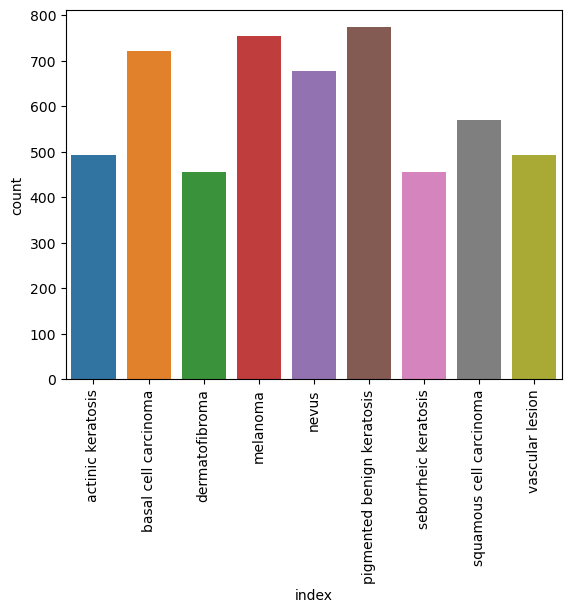

In [28]:
import seaborn as sns
sns.barplot(x='index', y = 'count', data=dist)
plt.xticks(rotation=90)
plt.show();

####  Write your findings here:
### - Which class has the least number of samples?

#### _"squamous cell carcinoma" has least number of samaples.(58)_


### - Which classes dominate the data in terms proportionate number of samples?
#### _"pigmented benign keratosis" has hightes proportionate number of samples(370)._

#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
path_to_training_dataset="CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1C15B02CA30>: 100%|█| 500/500 [00:02<00:


Initialised with 376 image(s) found.
Output directory set to CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1C149C65850>: 100%|█| 500/500 [00:02<00:


Initialised with 95 image(s) found.
Output directory set to CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C14283F370>: 100%|█| 500/500 [00:02<00:00, 170.66 Samples


Initialised with 438 image(s) found.
Output directory set to CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1C149C7D430>: 100%|█| 500/500 [00:18<00:00, 27.31 Samples


Initialised with 357 image(s) found.
Output directory set to CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x1C14260DD30>: 100%|█| 500/500 [00:16<00:00, 31.08 Samples/


Initialised with 462 image(s) found.
Output directory set to CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C14A9C0250>: 100%|█| 500/500 [00:02<00:00, 171.76 Samples


Initialised with 77 image(s) found.
Output directory set to CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1C14AB5EB50>: 100%|█| 500/500 [00:07<00:00, 65.28 Samples


Initialised with 181 image(s) found.
Output directory set to CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C14AA8C6D0>: 100%|█| 500/500 [00:02<00:00, 173.95 Samples


Initialised with 139 image(s) found.
Output directory set to CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C1479BD0A0>: 100%|█| 500/500 [00:02<00:00, 169.36 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
from glob import glob
import os

In [33]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['CNN_assignment\\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_56d7337e-08ef-4e62-be18-58f5c80cc625.jpg',
 'CNN_assignment\\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_6fffa5bd-3e21-4d8a-8961-92402ba7480d.jpg',
 'CNN_assignment\\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_78238277-d897-45b2-a493-4251b3cb51fe.jpg',
 'CNN_assignment\\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_8b9ec8dc-59b6-45d2-98d9-8d7b3a009c64.jpg',
 'CNN_assignment\\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_8c237434-9bf6-4a4e-8c66-f2bb3998b

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [35]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [36]:
dataframe_dict_new

{'CNN_assignment\\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_56d7337e-08ef-4e62-be18-58f5c80cc625.jpg': 'actinic keratosis',
 'CNN_assignment\\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_6fffa5bd-3e21-4d8a-8961-92402ba7480d.jpg': 'actinic keratosis',
 'CNN_assignment\\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_78238277-d897-45b2-a493-4251b3cb51fe.jpg': 'actinic keratosis',
 'CNN_assignment\\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_8b9ec8dc-59b6-45d2-98d9-8d7b3a009c64.jpg': 'actinic keratosis',
 'CNN_assignment\\Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration\\Train\\actinic keratosis\\o

In [37]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [38]:
df2['Label'].value_counts()

actinic keratosis             1000
basal cell carcinoma          1000
dermatofibroma                1000
melanoma                      1000
nevus                         1000
pigmented benign keratosis    1000
seborrheic keratosis          1000
squamous cell carcinoma       1000
vascular lesion               1000
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [39]:
batch_size = 32
img_height = 180
img_width = 180

####  Create a training dataset

In [40]:
data_dir_train=pathlib.Path("CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred',
  seed=123,
  label_mode="categorical",
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


####  Create a validation dataset

In [41]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred',
  seed=123,
  label_mode="categorical",
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


####  Create your model (make sure to include normalization)

In [42]:
## your code goes here
model_with_augmentor = Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180, 180, 3)),
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=9, activation='softmax')
])


####  Compile your model (Choose optimizer and loss function appropriately)

In [43]:
## your code goes here
model_with_augmentor.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model_with_augmentor.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 178, 178, 64)      1792      
                                                                 
 conv2d_9 (Conv2D)           (None, 176, 176, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 88, 88, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 86, 86, 32)        18464     
                                                                 
 conv2d_11 (Conv2D)          (None, 84, 84, 32)        9248      
                                                      

#### **Todo:**  Train your model

In [44]:
epochs = 20
history = model_with_augmentor.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
281/281 [==============================] - 667s 2s/step - loss: 2.0313 - accuracy: 0.2057 - val_loss: 1.8314 - val_accuracy: 0.3040
Epoch 2/20
281/281 [==============================] - 517s 2s/step - loss: 1.7631 - accuracy: 0.2969 - val_loss: 1.7272 - val_accuracy: 0.3667
Epoch 3/20
281/281 [==============================] - 528s 2s/step - loss: 1.5729 - accuracy: 0.3918 - val_loss: 1.3491 - val_accuracy: 0.4749
Epoch 4/20
281/281 [==============================] - 524s 2s/step - loss: 1.4476 - accuracy: 0.4455 - val_loss: 1.3408 - val_accuracy: 0.4833
Epoch 5/20
281/281 [==============================] - 541s 2s/step - loss: 1.3477 - accuracy: 0.4833 - val_loss: 1.3635 - val_accuracy: 0.4922
Epoch 6/20
281/281 [==============================] - 546s 2s/step - loss: 1.2497 - accuracy: 0.5168 - val_loss: 1.1132 - val_accuracy: 0.5915
Epoch 7/20
281/281 [==============================] - 552s 2s/step - loss: 1.1107 - accuracy: 0.5731 - val_loss: 0.9688 - val_accuracy: 0.6551

#### Visualize the model results

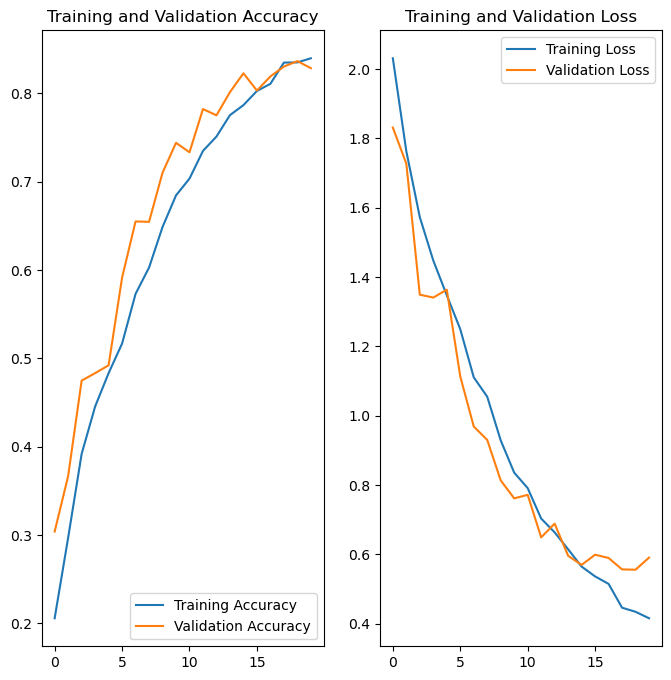

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

The model got a lot better when we balanced the different classes in the data. This made both the training and validation accuracies increase by a noticeable amount. This is much better than the original model, which had a problem with overfitting, and the model with random data changes, which had a problem with underfitting.


### Predit on new data

In [49]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,labels="inferred",label_mode="categorical",batch_size=batch_size,image_size=(img_height,img_width),seed = 123)

Found 118 files belonging to 9 classes.


In [52]:
model_with_augmentor.evaluate(test_ds, batch_size=batch_size, verbose=1)

4/4 [==============================] - 3s 315ms/step - loss: 7.4557 - accuracy: 0.3390


[7.455720901489258, 0.33898305892944336]